In [1]:
import cv2, random, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# 모델의 출력 outputs의 bbox를 필터링하는 nms 클래스
from yolo_v3_nms import Yolov3NMS

from pycocotools.coco import COCO

In [2]:
import torch
import darknet53_FPN as darknet53 #백본 모델 구성정보
from Yolov3_model import YOLOv3, FPN, debug # 나머지 모델레이어 구성정보
import coco_data # 전역변수 모음집

In [3]:
# 모델 초기화
backbone = darknet53.Darknet53(pretrained=False)
fpn = FPN(channels_list=coco_data.fpn_in_ch)
yolov3 = YOLOv3(backbone, fpn, num_classes=80)

In [4]:
import gdown #학습시킨 가중치 파일은 구글드라이브에 있음
import os

In [6]:
# 파일 ID 추출
file_id = "1-7kMFBkEMtch01l2JajgIaTFnc1qHwzr"
# 다운로드 링크 생성
download_url = f"https://drive.google.com/uc?id={file_id}"
# 파일 다운로드
output_file = "Yolo_v3_final.pth"

# 파일 다운로드
if not os.path.exists(output_file):
    gdown.download(download_url, output_file, quiet=False)
    print("다운로드 완료")
else:
    print("파일이 이미 존재함")

파일이 이미 존재함


In [7]:
# 다운로드받은 가중치 파일을 붙여서 Pretrined-model로 만들기
yolov3.load_weights('Yolo_v3_final.pth')

In [8]:
# coco데이터셋의 메인 루트 디렉토리
root_dir = './../00_pytest_img/COCO dataset'
anno_path = os.path.join(root_dir, 'annotations')
load_anno = 'val2014'
json_file = 'instances_' + load_anno + '.json'
coco = COCO(os.path.join(anno_path, json_file))

loading annotations into memory...
Done (t=4.41s)
creating index...
index created!


In [24]:
# 임의의 이미지 하나 선택하기
img_ids = coco.getImgIds()
chosen_img = random.choice(img_ids)

img_info = coco.loadImgs(chosen_img)[0]
ann_ids = coco.getAnnIds(imgIds=img_info['id'])
img_file_name = img_info['file_name']
print(f"선택Img: {img_file_name}")
print(f"객체개수: {len(ann_ids)}")
print(f"이미지 크기 [W: {img_info['width']}, H:{img_info['height']}]")

선택Img: COCO_val2014_000000227884.jpg
객체개수: 3
이미지 크기 [W: 444, H:640]


In [25]:
# 이미지 불러오기 및 전처리
image_path =  os.path.join(root_dir, load_anno, img_file_name)
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (416, 416))
image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

In [26]:
# gt_box 정보 추출하기
ann_ids = coco.getAnnIds(imgIds=chosen_img)
anns = coco.loadAnns(ann_ids)

gt_boxes = []

for ann in anns:
    bbox = ann['bbox']
    # CP는 Class Probability이니 = Class ID
    CP_idx = coco_data.real_class_idx[ann['category_id']]

    x, y, w, h = bbox
    # bbox 좌표 정규화
    bx = (x + w / 2) / img_info['width']
    by = (y + h / 2) / img_info['height']
    bw = w / img_info['width']
    bh = h / img_info['height']

    gt_box = torch.tensor([bx, by, bw, bh, 1, CP_idx])
    gt_boxes.append(gt_box)

gt_boxes = sorted(gt_boxes, key=lambda box: (box[5], box[2] * box[3]))

# 정규 좌표평면상으로 변환한 GT_b_series_bbox 좌표 리스트 출력
for gt_box in gt_boxes:
    print(gt_box)

tensor([0.4725, 0.6353, 0.4080, 0.3647, 1.0000, 0.0000])
tensor([ 0.5083,  0.6606,  0.0347,  0.0416,  1.0000, 27.0000])
tensor([ 0.5024,  0.7159,  0.0465,  0.1526,  1.0000, 27.0000])


In [27]:
# 모델 추론
with torch.no_grad():
    outputs = yolov3(image_tensor)

# NMS 적용을 위한 nms 클래스 인스턴스화
# 이때 `anchor` 변수는 앞서 정규 좌표평면의 anthor_box_list를 인자로
nms = Yolov3NMS(conf_th=0.4, anchor=coco_data.anchor_box_list)
# 아래의 메서드가 수행되면 [tx, ty, tw, th] -> [bx, by, bw, bh] 좌표변환
# 그 이후 NMS 필터가 한번에 다 돌아감
boxes = nms.non_max_suppression(outputs)

boxes = sorted(boxes, key=lambda box: (box[5], box[2] * box[3]))

# 최종 모델이 추론한 정보인 B_series_bbox 좌표 리스트 출력
for box in boxes:
    print(box)


tensor([0.5037, 0.6646, 0.3915, 0.4490, 0.9808, 0.0000])
tensor([ 0.4891,  0.7444,  0.0395,  0.1819,  0.8524, 27.0000])
tensor([1.2978e-01, 4.7646e-01, 1.2965e-02, 4.3520e-02, 5.3757e-01, 7.3000e+01])


In [28]:
# 결과 시각화 함수
def plot_boxes(image, boxes, labels):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # 정규 좌표값 boxes를 원래 값으로 복원
    scale_y = image.shape[0] # height
    scale_x = image.shape[1] # width
    boxes = [[box[0] * scale_x, # x_center * width
              box[1] * scale_y, # y_center * height
              box[2] * scale_x, # w * width
              box[3] * scale_y, # h * height
              box[4], box[5]] for box in boxes]

    for box in boxes:
        x_center, y_center, w, h, conf, label = box
        # bbox를 그리는데 좌 상단 좌표, width, hight 필요
        x1 = x_center - w / 2
        y1 = y_center - h / 2

        # 라벨의 텍스트 좌표 및 bbox의 색깔 정하기
        label = int(label)
        superclass = coco_data.cls_map[label]
        color = coco_data.cls_color[superclass]

        rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, s=labels[label], color='black', verticalalignment='top',
                 bbox={'color': color, 'pad': 0})

    plt.axis('off')
    plt.show()

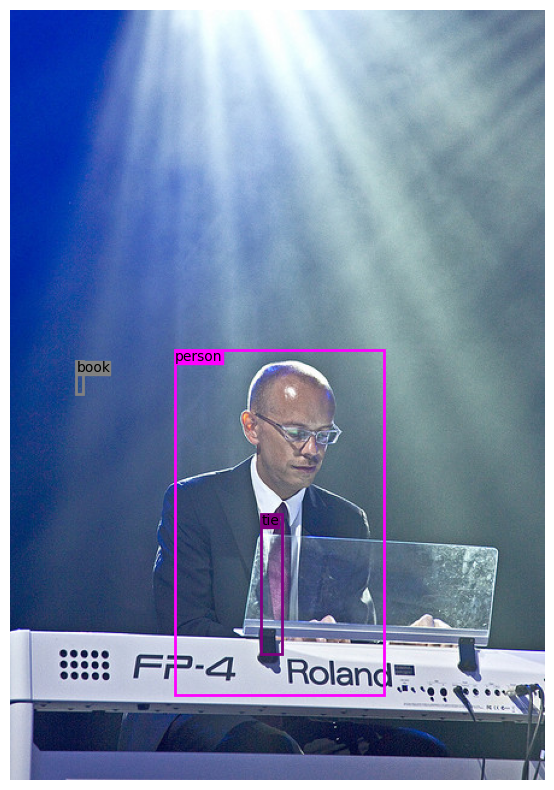

In [29]:
# 모델 추론 결과 -> B_series좌표변환 -> NMS 필터 후 결과 시각화
plot_boxes(image_rgb, boxes, coco_data.coco_label)

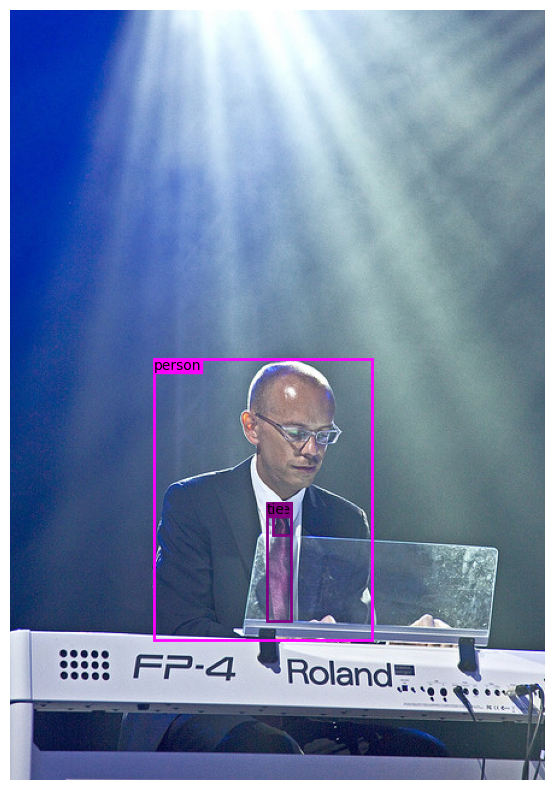

In [30]:
# Ground_Truth 좌표에 대한 결과 시각화
plot_boxes(image_rgb, gt_boxes, coco_data.coco_label)